## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.distributions import Uniform, Normal
from torchmetrics import Accuracy

from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

PATH_DATASETS = "."
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

In [3]:
torch.manual_seed(8407)

## Play with data

In [4]:
def gen_uniform(N):
    u = Uniform(-4, 4)
    return u.sample((N,))

def gen_normal(theta, N):
    n = Normal(loc=theta, scale=0.25)
    return n.sample((N,))

In [5]:
N = 60000

In [6]:
x0 = gen_uniform(N)
x1 = torch.column_stack([gen_normal(th, N) for th in [-2,-1,0,1,2]])

In [7]:
x1.shape

torch.Size([60000, 5])

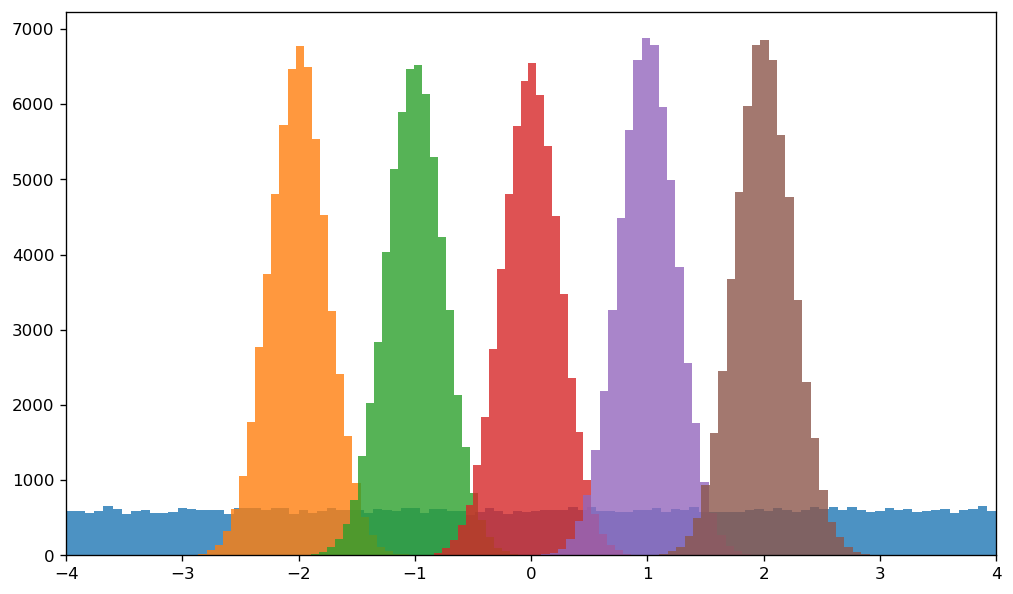

In [8]:
plt.figure(figsize=(10, 6), dpi=120)
plt.hist(x0.detach().numpy(), bins=100, alpha=0.8)
plt.hist(x1[:,0].detach().numpy(), bins=30, alpha=0.8)
plt.hist(x1[:,1].detach().numpy(), bins=30, alpha=0.8)
plt.hist(x1[:,2].detach().numpy(), bins=30, alpha=0.8)
plt.hist(x1[:,3].detach().numpy(), bins=30, alpha=0.8)
plt.hist(x1[:,4].detach().numpy(), bins=30, alpha=0.8)
plt.xlim([-4, 4])
plt.show()

## Create LightningModule

In [9]:
class ToyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
class MLP(LightningModule):
    def __init__(self, N=60000, hidden_size=64, learning_rate=2e-4, thetas=None):
        super().__init__()

        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )

        self.accuracy = Accuracy()
        
        self.N=N
        if thetas is None:
            thetas = torch.tensor([-2., -1., 0., 1., 2.])
        self.thetas = thetas
        self.ds = None

    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy(logits, y)
        preds = torch.round(logits)
        acc = self.accuracy(preds, y.to(torch.int32))

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self) -> None:
        # Background
        x0 = gen_uniform(self.N // 2) # 30000
        th0_ics = torch.randint(0, len(self.thetas), (len(x0),))
        th0 = self.thetas[th0_ics]
        bg = torch.column_stack([x0, th0])
        l0 = torch.zeros((bg.shape[0],1))

        # Signals
        n = (self.N // 2) // 5 # 6000
        data = torch.zeros((self.N // 2, 2))
        for (i, th) in enumerate(self.thetas):
            # if i == len(self.thetas)-1:
            #     n = self.N // 2 - 4*n
            xi = gen_normal(th, n)
            thi = torch.ones_like(xi) * th
            data[i*n:(i+1)*n, 0] = xi
            data[i*n:(i+1)*n, 1] = thi
        l1 = torch.ones((data.shape[0],1))

        self.ds = ToyDataset(
            torch.row_stack([bg, data]),
            torch.row_stack([l0, l1])
        )

    def setup(self, stage=None) -> None:
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [55000, 5000])

        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=BATCH_SIZE)

In [11]:
model = MLP()

trainer = Trainer(
    max_epochs=50,
    progress_bar_refresh_rate=20,
    gpus=AVAIL_GPUS,
    callbacks=[EarlyStopping(monitor="val_loss")]
)

/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
# trainer.fit(model, dm)
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /home/xteca/Documents/Project/Machine_Learning/PML/lightning_logs

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 4.4 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
trainer.test()

/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1398: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/xteca/Documents/Project/Machine_Learning/PML/lightning_logs/version_0/checkpoints/epoch=25-step=5589.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/xteca/Documents/Project/Machine_Learning/PML/lightning_logs/version_0/checkpoints/epoch=25-step=5589.ckpt
/home/xteca/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.9118000268936157, 'val_loss': 0.23426730930805206}
--------------------------------------------------------------------------------


[{'val_loss': 0.23426730930805206, 'val_acc': 0.9118000268936157}]

In [14]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Reconstruct

In [15]:
def predict(theta, domain):
    thetas = torch.ones_like(domain) * theta
    data = torch.column_stack([domain, thetas])
    return model(data)

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

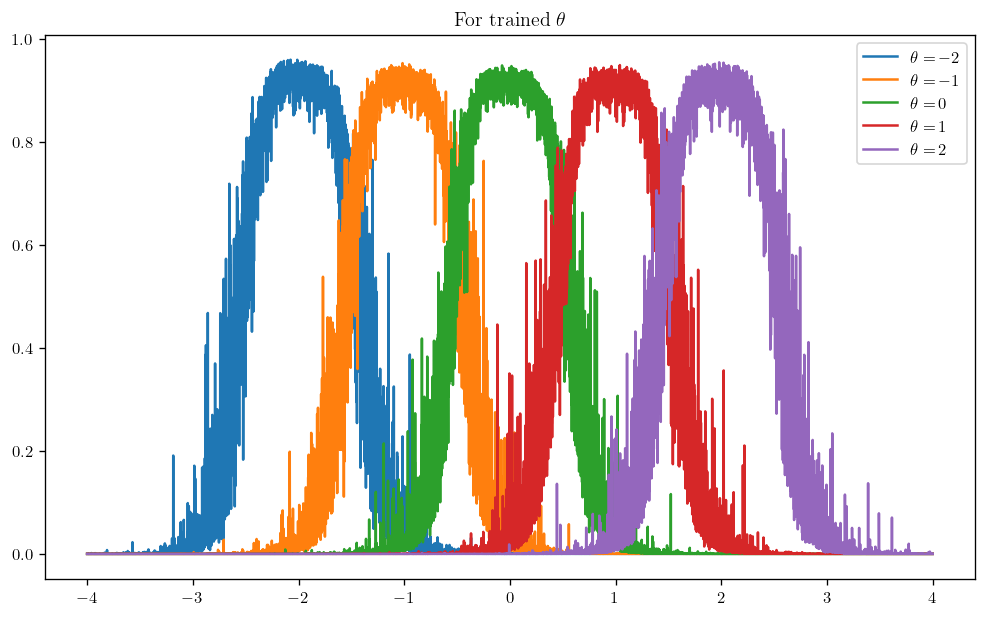

In [17]:
thetas = [-2,-1,0,1,2]

x = torch.linspace(-4, 4, 10000)
ys = [predict(th, x) for th in thetas]

plt.figure(figsize=(10,6), dpi=120)
plt.title(r"For trained $\theta$")
for (i, th) in enumerate([-2,-1,0,1,2]):
    plt.plot(x.detach().numpy(), ys[i].detach().numpy(), label=r"$\theta = $"+f"$\,{th}$")
plt.legend()
plt.savefig("fig/exact_th.png", dpi=300)
plt.show()

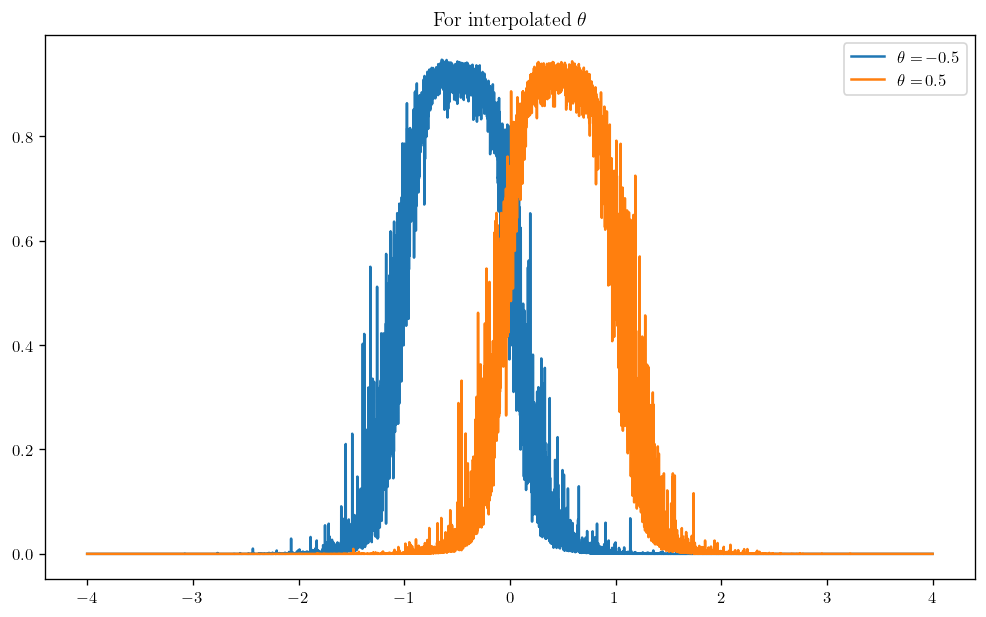

In [18]:
thetas = [-0.5, 0.5]
ys = [predict(th, x) for th in thetas]

plt.figure(figsize=(10,6), dpi=120)
plt.title(r"For interpolated $\theta$")
for (i, th) in enumerate(thetas):
    plt.plot(x.detach().numpy(), ys[i].detach().numpy(), label=r"$\theta = $"+f"$\,{th}$")
plt.legend()
plt.savefig("fig/interpolate_th.png", dpi=300)
plt.show()

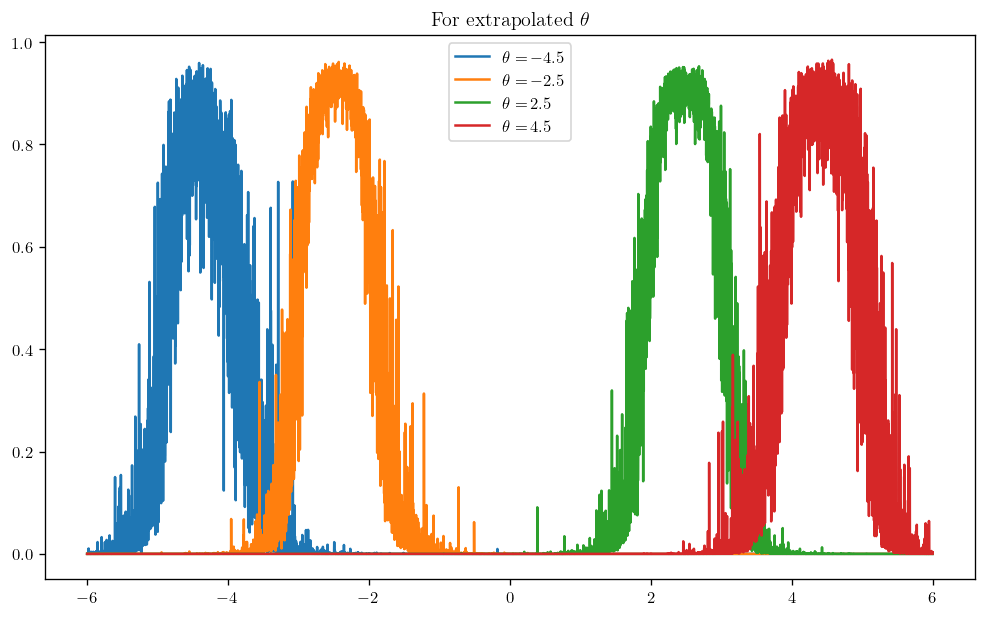

In [19]:
thetas = [-4.5, -2.5, 2.5, 4.5]
x = torch.linspace(-6, 6, 10000)
ys = [predict(th, x) for th in thetas]

plt.figure(figsize=(10,6), dpi=120)
plt.title(r"For extrapolated $\theta$")
for (i, th) in enumerate(thetas):
    plt.plot(x.detach().numpy(), ys[i].detach().numpy(), label=r"$\theta = $"+f"$\,{th}$")
plt.legend()
plt.savefig("fig/extrapolate_th.png", dpi=300)
plt.show()

--------------

## Legacy

In [20]:
# class ToyDataModule(LightningDataModule):
#     def __init__(self, N=60000, thetas=None):
#         super().__init__()
#         self.N=N
#         if thetas is None:
#             thetas = torch.tensor([-2., -1., 0., 1., 2.])
#         self.thetas = thetas
#         self.ds = None

#     def prepare_data(self) -> None:
#         # Background
#         x0 = gen_uniform(self.N // 2) # 30000
#         th0 = torch.randint(0, len(self.thetas), (len(x0),)) # 30000
#         bg = torch.column_stack([x0, th0])
#         l0 = torch.zeros((bg.shape[0],1))

#         # Signals
#         n = (self.N // 2) // 5 # 6000
#         data = torch.zeros((self.N // 2, 2))
#         for (i, th) in enumerate(self.thetas):
#             # if i == len(self.thetas)-1:
#             #     n = self.N // 2 - 4*n
#             xi = gen_normal(th, n)
#             thi = torch.ones_like(xi) * th
#             data[i*n:(i+1)*n, 0] = xi
#             data[i*n:(i+1)*n, 1] = thi
#         l1 = torch.ones((data.shape[0],1))

#         self.ds = ToyDataset(
#             torch.row_stack([bg, data]),
#             torch.row_stack([l0, l1])
#         )

#     def setup(self, stage=None) -> None:
#         if stage == "fit" or stage is None:
#             self.ds_train, self.ds_val = random_split(self.ds, [55000, 5000])

#         if stage == "test" or stage is None:
#             _, self.ds_test = random_split(self.ds, [55000, 5000])

#     def train_dataloader(self):
#         return DataLoader(self.ds_train, batch_size=BATCH_SIZE)

#     def val_dataloader(self):
#         return DataLoader(self.ds_val, batch_size=BATCH_SIZE)

#     def test_dataloader(self):
#         return DataLoader(self.ds_test, batch_size=BATCH_SIZE)